<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/__draft___gated_pixel_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 117 (delta 61), reused 26 (delta 11), pack-reused 0
Receiving objects: 100% (117/117), 13.49 MiB | 4.34 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from torchvision import datasets

In [3]:
BATCH_SIZE = 32
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    lambda x: distributions.Bernoulli(probs=x).sample()])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE*2)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [55]:
# TODO(eugenhotaj): We should rethink the Masked layers. It might make sense to 
# just have a generic MaskedConv2d layer which takes in whatever kind of mask 
# in the __init__. We can then have different functions which generate masks 
# from specific papers.

class MaskedConv2d(nn.Conv2d):

  EXCLUDE_SELF = 0
  INCLUDE_SELF = 1

  def __init__(self, mask_type, *args, **kwargs):
    super().__init__(*args, **kwargs)

    i, o, h, w = self.weight.shape
    # TODO(eugenhotaj): Will this masking logic work correctly for even kernel 
    # sizes? If not, maybe we should raise an exception instead.
    mask = torch.zeros((i, o, h, w))
    mask.data[:, :, :h//2, :] = 1
    mask.data[:, :, h//2, :w//2 + mask_type] = 1
    self.register_buffer('mask', mask)

  def forward(self, x):
    self.weight.data *= self.mask
    return super().forward(x)

class MaskedVerticalConv2d(nn.Conv2d):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    i, o, h, w = self.weight.shape
    mask = torch.zeros(i, o, h, w)
    mask[:, :, :h//2 + 1, :] = 1
    self.register_buffer('mask', mask)

  def forward(self, x):
    self.weight.data *= self.mask
    return super().forward(x)

class MaskedHorizontalConv2d(nn.Conv2d):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    i, o, h, w = self.weight.shape
    mask = torch.zeros(i, o, h, w)
    mask[:, :, :, :w//2 + 1] = 1
    self.register_buffer('mask', mask)

  def forward(self, x):
    self.weight.data *= self.mask
    return super().forward(x)


class GatedPixelCNNLayer(nn.Module):

  def __init__(self, channels, kernel_size=3):
    super().__init__()
    self._channels = channels
    self._kernel_size = kernel_size
    self._padding = (kernel_size - 1)//2 # padding = (kernel_size - stride) / 2 

    self._vertical_stack = nn.Sequential(
        nn.Conv2d(
            in_channels=self._channels, out_channels=self._channels,
            kernel_size=(1, self._kernel_size), padding=(0, self._padding)),
        MaskedVerticalConv2d(
            in_channels=self._channels, out_channels=2*self._channels, 
            kernel_size=(self._kernel_size, 1), padding=(self._padding, 0)))
    self._horizontal_stack = MaskedHorizontalConv2d(
        in_channels=self._channels, out_channels=2*self._channels, 
        kernel_size=(1, self._kernel_size), padding=(0, self._padding))

  def _shift_up(self, tensor):
    # TODO(eugenhotaj): Should we copy the tensor here before shifting?
    tensor = torch.roll(tensor, self._kernel_size - 1, dims=2) # Assuming NCHW
    tensor[:, :, self._kernel_size//2 + 1:, :] = 0
    return tensor

  def forward(self, vstack, hstack):
    # Compute the vertical stack. 
    vstack = self._vertical_stack(vstack)
    vtanh, vsigmoid = torch.split(vstack, self._channels, dim=1) # Assuming NCHW 
    new_vstack = torch.tanh(vtanh) * torch.sigmoid(vsigmoid)

    # Compute the horizontal stack.
    hstack_ = self._shift_up(vstack) + self._horizontal_stack(hstack)
    htanh, hsigmoid = torch.split(hstack_, self._channels, dim=1) # Assuming NHCW
    new_hstack = (torch.tanh(htanh) * torch.sigmoid(hsigmoid)) + hstack

    return new_vstack, new_hstack

In [56]:
class GatedPixelCNN(nn.Module):

  def __init__(self, 
               in_channels, 
               hidden_channels=16,
               head_channels=32,
               n_gated=4):
    """TODO"""

    super().__init__()

    self._input =  MaskedConv2d(mask_type=MaskedConv2d.EXCLUDE_SELF,
                                in_channels=in_channels,
                                out_channels=hidden_channels,
                                kernel_size=7,
                                padding=3)
    self._gated_layers = nn.ModuleList([
        GatedPixelCNNLayer(channels=hidden_channels) for _ in range(n_gated)])
    self._head = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_channels, 
                  out_channels=head_channels, 
                  kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=head_channels, 
                  out_channels=in_channels,
                  kernel_size=1),
        nn.Sigmoid())

  def forward(self, x):
    x = self._input(x)
    vstack, hstack = x, x
    skip_connections = torch.zeros_like(x)
    for gated_layer in self._gated_layers:
      vstack, hstack = gated_layer(vstack, hstack)
      skip_connections += hstack
    return self._head(skip_connections)


  def sample(self):
    """Samples a new image.
    
    Args:
      conditioned_on: An (optional) image to condition samples on. Only 
        dimensions with values < 0 will be sampled. For example, if 
        conditioned_on[i] = -1, then output[i] will be sampled conditioned on
        dimensions j < i. If 'None', an unconditional sample will be generated.
    """
    with torch.no_grad():
      device = next(self.parameters()).device
      conditioned_on = (torch.ones((1, 1,  28, 28)) * - 1).to(device)

      for channel in range(1):
        for row in range(28):
          for column in range(28):
            out = self.forward(conditioned_on)[:, channel, row, column]
            out = distributions.Bernoulli(probs=out).sample()
            conditioned_on[:, channel, row, column] = torch.where(
                conditioned_on[:, channel, row, column] < 0,
                out, 
                conditioned_on[:, channel, row, column])
      return conditioned_on

In [ ]:
IN_CHANNELS = 1
HIDDEN_CHANNELS = 16
HEAD_CHANNELS = 32
N_GATED = 12

N_EPOCHS = 50

torch.cuda.empty_cache()
model = GatedPixelCNN(IN_CHANNELS, 
                 HIDDEN_CHANNELS, 
                 HEAD_CHANNELS, 
                 N_GATED).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')

def loss_fn(x, _, preds):
  batch_size = x.shape[0]
  x, preds = x.view((batch_size, -1)), preds.view((batch_size, -1))
  return bce_loss_fn(preds, x).sum(dim=1).mean()

train_losses, eval_losses = colab_utils.train_andor_evaluate(
    model, 
    loss_fn, 
    optimizer=optimizer, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader,
    eval_loader=test_loader,
    device=colab_utils.get_device())

[1|506]: train_loss=106.20682958984375 eval_loss=98.16675874023437
[2|506]: train_loss=97.92010666910808 eval_loss=97.39951292724609
[3|507]: train_loss=97.12032529703777 eval_loss=96.39649327392578
[4|505]: train_loss=96.76806313476563 eval_loss=96.11171619873046
[5|506]: train_loss=96.44096451822917 eval_loss=95.79934956054687
[6|506]: train_loss=96.15460087890625 eval_loss=95.81229836425781


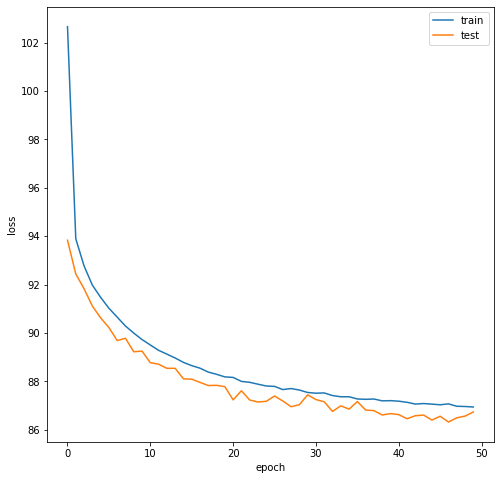

In [ ]:
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].unsqueeze(0).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))


def sample(model):
  colab_utils.imshow(model.sample().reshape(28, 28))


def conditional_sample_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img[0, 300:600] = -1
  colab_utils.imshow(img.reshape(28, 28))
  plt.show()
  print("Conditional Samples:")
  for i in range(5):
    img_hat = model.sample(img)
    colab_utils.imshow(img_hat.reshape(28, 28))

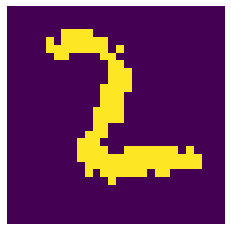

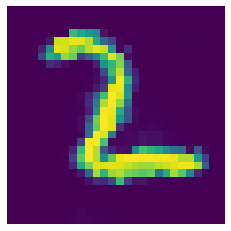

In [ ]:
show_random(model, test_loader.dataset)

In [ ]:
model_weights = model.state_dict()
model = PixelCNN(IN_CHANNELS, HIDDEN_CHANNELS, HEAD_CHANNELS).to(
    colab_utils.get_device())
model.load_state_dict(model_weights)

<All keys matched successfully>

In [ ]:
sample(model)